In [ ]:
pip install -U imbalanced-learn

In [27]:
from collections import Counter
import numpy as np
from sklearn.datasets import make_classification
from imblearn.under_sampling import (
    ClusterCentroids,
    RandomUnderSampler,
    EditedNearestNeighbours,
    RepeatedEditedNearestNeighbours,
    NearMiss
)
from imblearn.over_sampling import RandomOverSampler, SMOTE, ADASYN
from imblearn.combine import SMOTETomek, SMOTEENN
from sklearn.datasets import fetch_openml

# 1) Overview

[Synthetic Data](https://medium.com/blog-do-zouza/have-you-heard-of-synthetic-data-15b562d6a166)

# 2) Undersampling

[imblearn undersampling documentation](https://imbalanced-learn.org/dev/under_sampling.html#condensed-nearest-neighbors)

Prototype selection algorithms can be divided into two groups:

1. Controlled under-sampling methods reduce the number of observations in the majority class or classes to an arbitrary number of samples specified by the user. Typically, they reduce the number of observations to the number of samples observed in the minority class.

2. Cleaning under-sampling techniques “clean” the feature space by removing either “noisy” or “too easy to classify” observations, depending on the method. The final number of observations in each class varies with the cleaning method and cant be specified by the user.



## 2.1 ClusterCentroids
ClusterCentroids makes use of K-means to reduce the number of samples. Therefore, each class will be synthesized with the centroids of the K-means method instead of the original samples

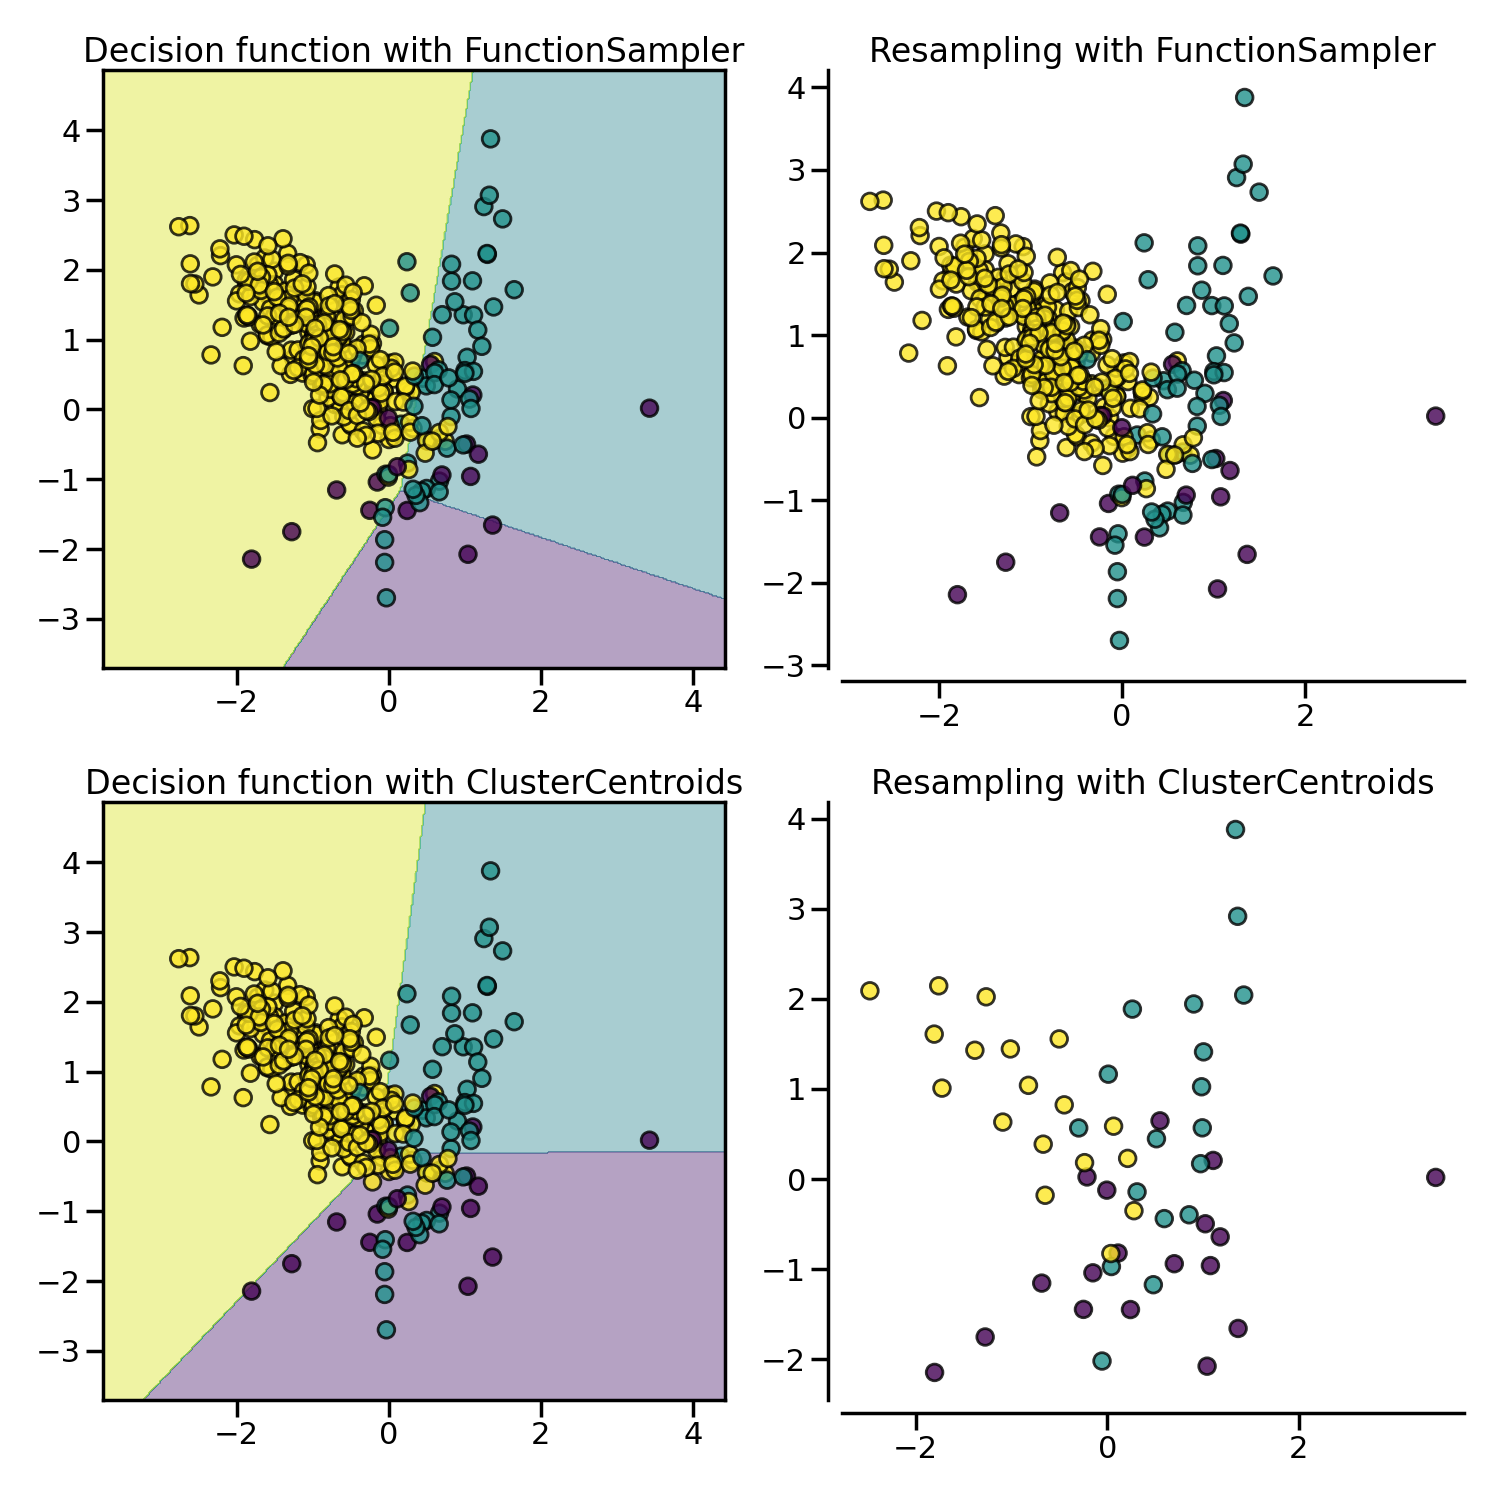

In [ ]:
X, y = make_classification(
    n_samples=5000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=3,
    n_clusters_per_class=1,
    weights=[0.01, 0.05, 0.94],
    class_sep=0.8, random_state=0
)
print('Oriignal Data: ', sorted(Counter(y).items()))

cc = ClusterCentroids(random_state=0)
X_resampled, y_resampled = cc.fit_resample(X, y)
print('Authentic Data: ', sorted(Counter(y_resampled).items()))

Oriignal Data:  [(0, 64), (1, 262), (2, 4674)]


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Authentic Data:  [(0, 64), (1, 64), (2, 64)]


## 2.2 Random under-sampling (controlled)

Balance the data by randomly selecting a subset of data for the targeted classes

In [ ]:
rus = RandomUnderSampler(random_state=0)
X_resampled, y_resampled = rus.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 64), (1, 64), (2, 64)]


In [ ]:
# heterogeneous data types
X_hetero = np.array(
    [['xxx', 1, 1.0], ['yyy', 2, 2.0], ['zzz', 3, 3.0]], dtype=object
)
y_hetero = np.array([0, 0, 1])
X_resampled, y_resampled = rus.fit_resample(X_hetero, y_hetero)
print(X_resampled, y_resampled)

[['yyy' 2 2.0]
 ['zzz' 3 3.0]] [0 1]


In [ ]:
# pandas dataframes
df_adult, y_adult = fetch_openml('adult', version=2, as_frame=True, return_X_y=True)
print(df_adult.shape)
df_resampled, y_resampled = rus.fit_resample(df_adult, y_adult)
print(df_resampled.shape)

/usr/local/lib/python3.10/dist-packages/sklearn/datasets/_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


(48842, 14)
(23374, 14)


## 2.3 Edited nearest neighbours (cleanning)

Uses K-Nearest Neighbours to identify the neighbours of the targeted class samples, and then removes observations if any or most of their neighbours are from a different class.

1. Train a K-Nearest neighbours using the entire dataset.
2. Find each observations' K closest neighbours (only for the targeted classes).
3. Remove observations if any or most of its neighbours belong to a different class.

EditedNearestNeighbours will retain observations from the majority class when most, or all of its neighbours are from the same class. To control this behaviour we set ```kind_sel='mode'``` or ```kind_sel='all'```, respectively. Hence, ```kind_sel='all'``` is less conservative than ```kind_sel='mode'```, resulting in the removal of more samples.

The parameter ```n_neighbors``` accepts integers. The integer refers to the number of neighbours to examine for each sample. It can also take a classifier subclassed from KNeighborsMixin from scikit-learn. When passing a classifier, note that, if you pass a 3-Nearest Neighbors classifier, only 2 neighbours will be examined for the cleaning, as the third sample is the one being examined for undersampling since it is part of the samples provided at fit.

In [ ]:
enn = EditedNearestNeighbours()
X_resampled, y_resampled = enn.fit_resample(X, y)
print(sorted(Counter(y).items()))
print(sorted(Counter(y_resampled).items()))

[(0, 64), (1, 262), (2, 4674)]
[(0, 64), (1, 213), (2, 4568)]


In [ ]:
# RepeatedEditedNearestNeighbours extends EditedNearestNeighbours multiple times
# more aggresive
renn = RepeatedEditedNearestNeighbours()
X_resampled, y_resampled = renn.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 64), (1, 208), (2, 4551)]


## 2.4 NearMiss
NearMiss is an under-sampling technique. It aims to balance class distribution by randomly eliminating majority class examples. When instances of two different classes are very close to each other, we remove the instances of the majority class to increase the spaces between the two classes. This helps in the classification process. To prevent problem of information loss in most under-sampling techniques, near-neighbor methods are widely used.

1) The method first finds the distances between all instances of the majority class and the instances of the minority class. Here, majority class is to be under-sampled.

2) Then, n instances of the majority class that have the smallest distances to those in the minority class are selected.

3) If there are k instances in the minority class, the nearest method will result in k*n instances of the majority class. For finding n closest instances in the majority class, there are several variations of applying NearMiss Algorithm :

* Version 1 : It selects samples of the majority class for which average distances to the k closest instances of the minority class is smallest.
* Version 2 : It selects samples of the majority class for which average distances to the k farthest instances of the minority class is smallest.
* Version 3 : It works in 2 steps. Firstly, for each minority class instance, their M nearest-neighbors will be stored. Then finally, the majority class instances are selected for which the average distance to the N nearest-neighbors is the largest.

When under-sampling a specific class, NearMiss-1 can be altered by the presence of noise. In fact, it will implied that samples of the targeted class will be selected around these samples as it is the case in the illustration below for the yellow class. However, in the normal case, samples next to the boundaries will be selected. NearMiss-2 will not have this effect since it does not focus on the nearest samples but rather on the farthest samples.

We can imagine that the presence of noise can also altered the sampling mainly in the presence of marginal outliers. NearMiss-3 is probably the version which will be less affected by noise due to the first step sample selection.

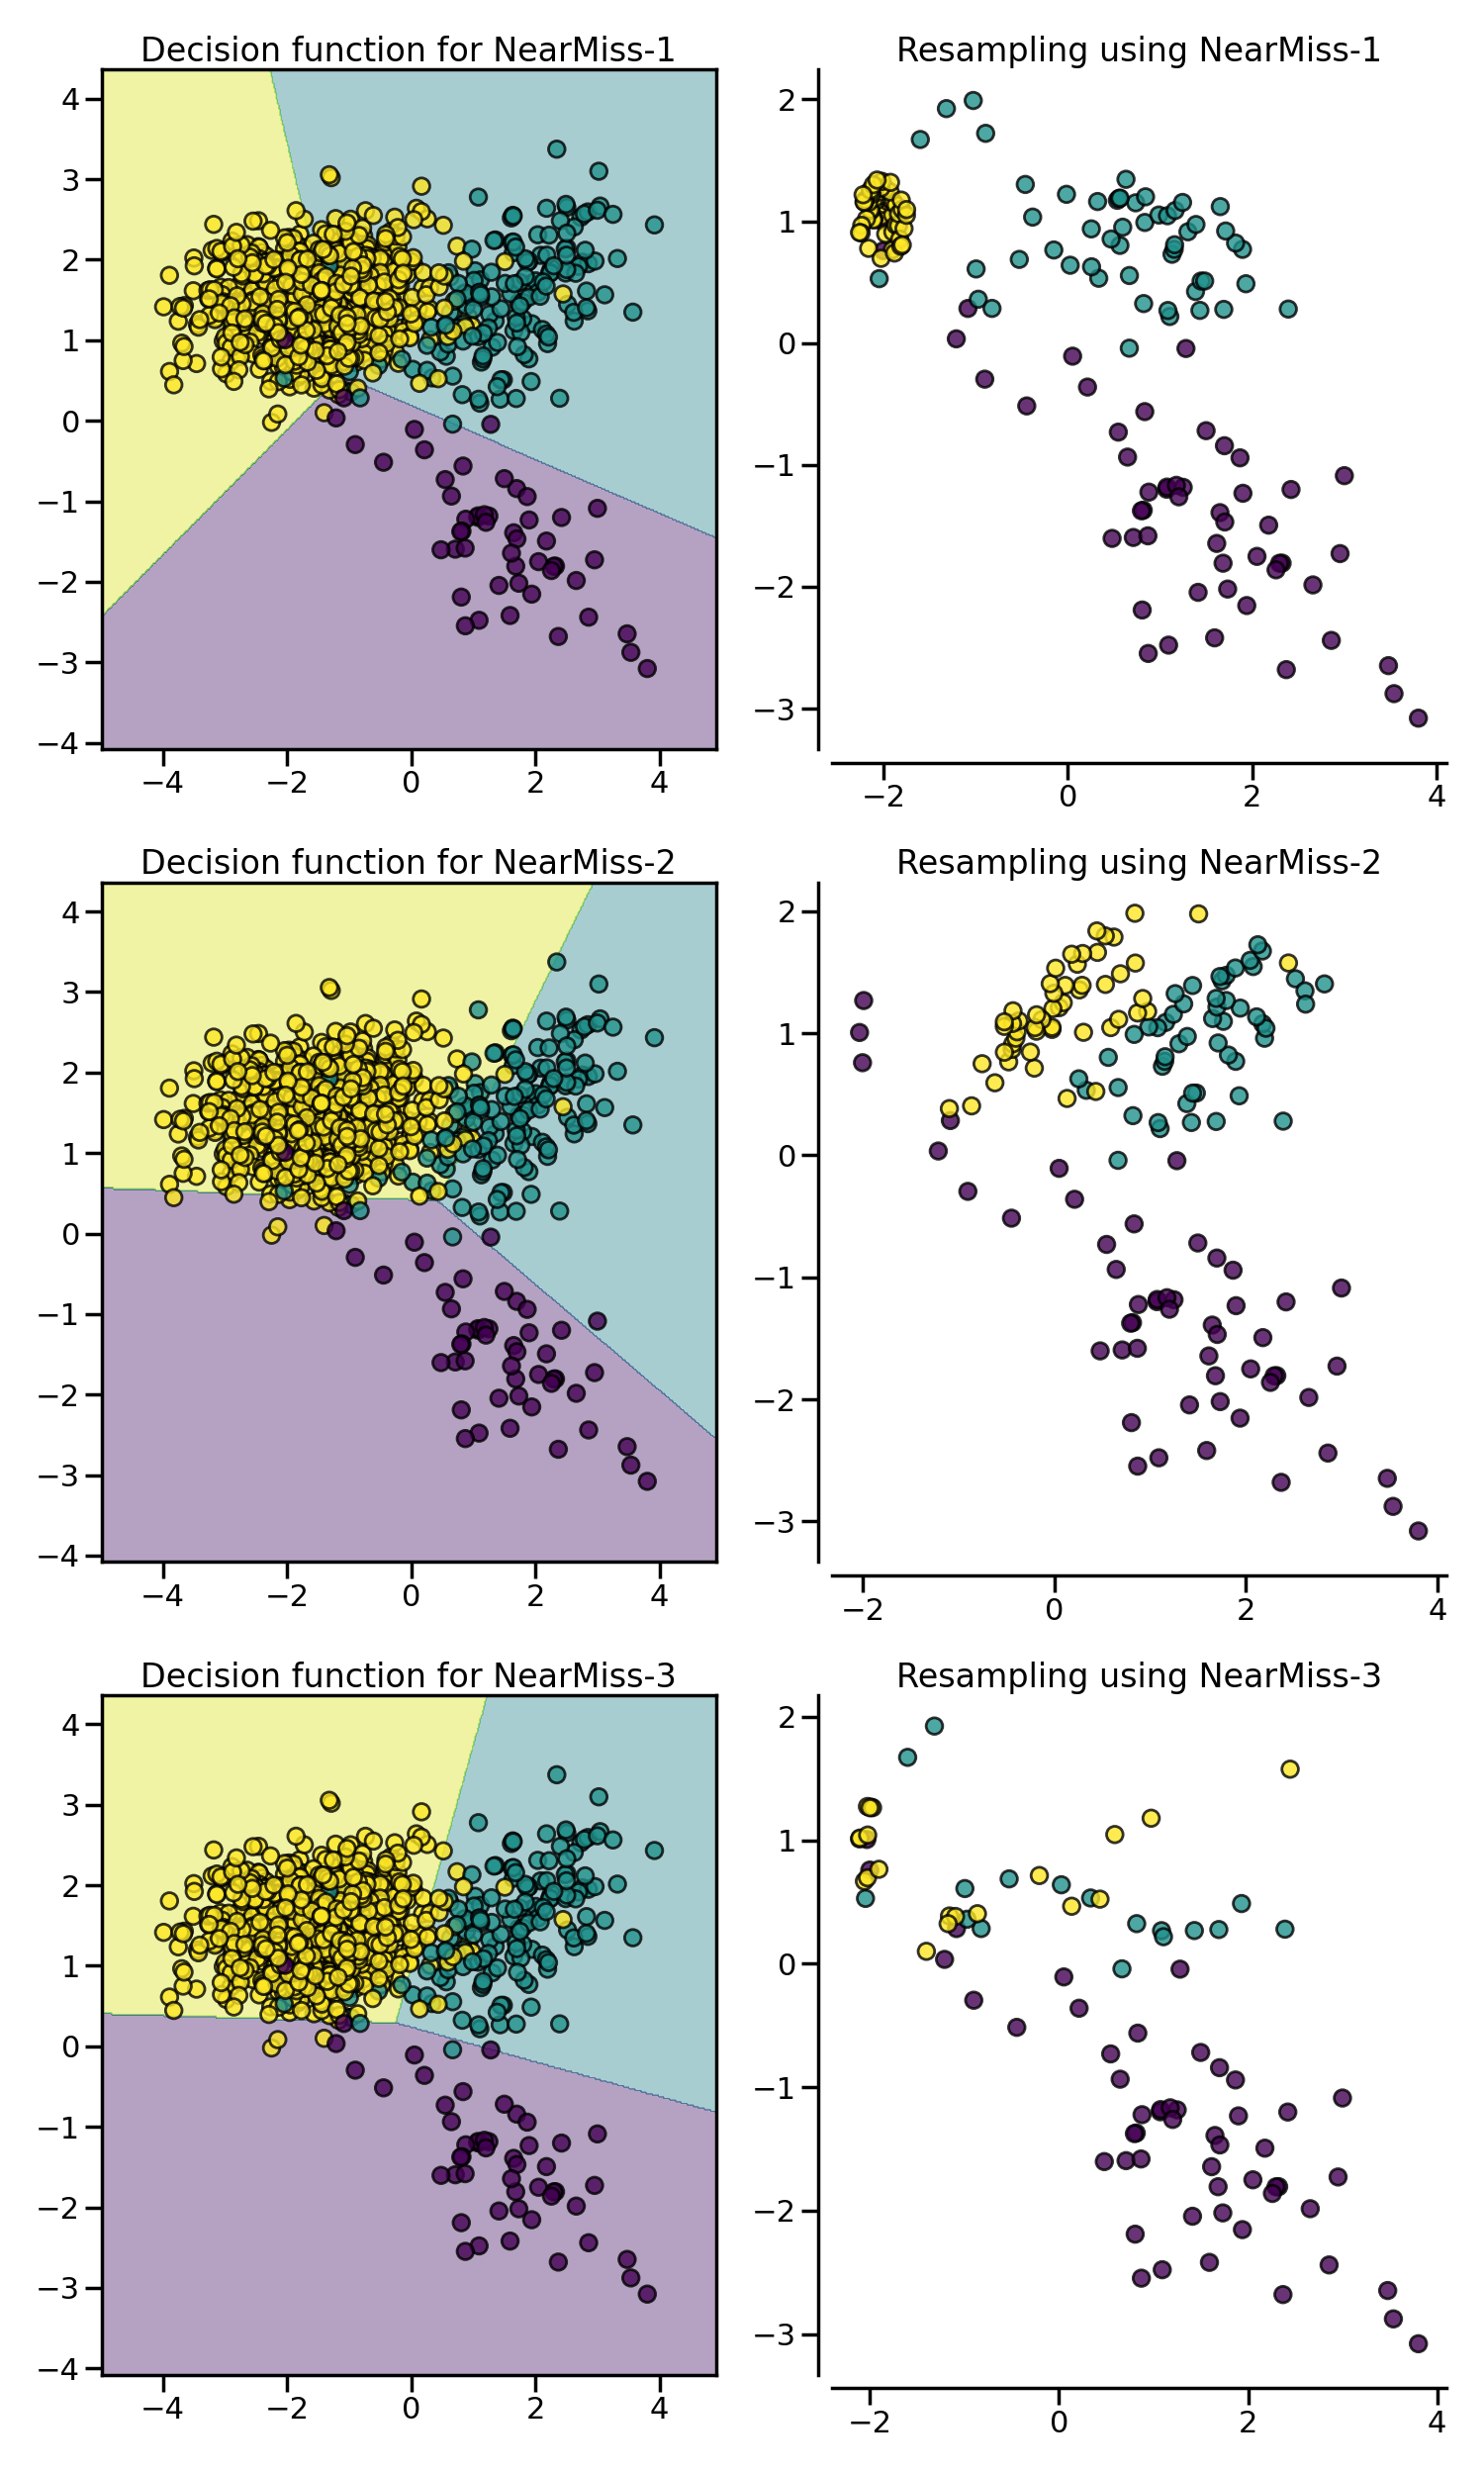



In [29]:
X, y = make_classification(
    n_samples=5000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=3,
    n_clusters_per_class=1,
    weights=[0.01, 0.05, 0.94],
    class_sep=0.8, random_state=0
)

nr = NearMiss()
X_resampled, y_resampled = nr.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 64), (1, 64), (2, 64)]


# 3) Upsampling

[Imblearn Upsampling Documentation](https://imbalanced-learn.org/stable/references/generated/imblearn.over_sampling.SMOTE.html)

## 3.1 Naive random over-sampling

Generate new samples by randomly sampling with replacement the current available samples (repeating samples)

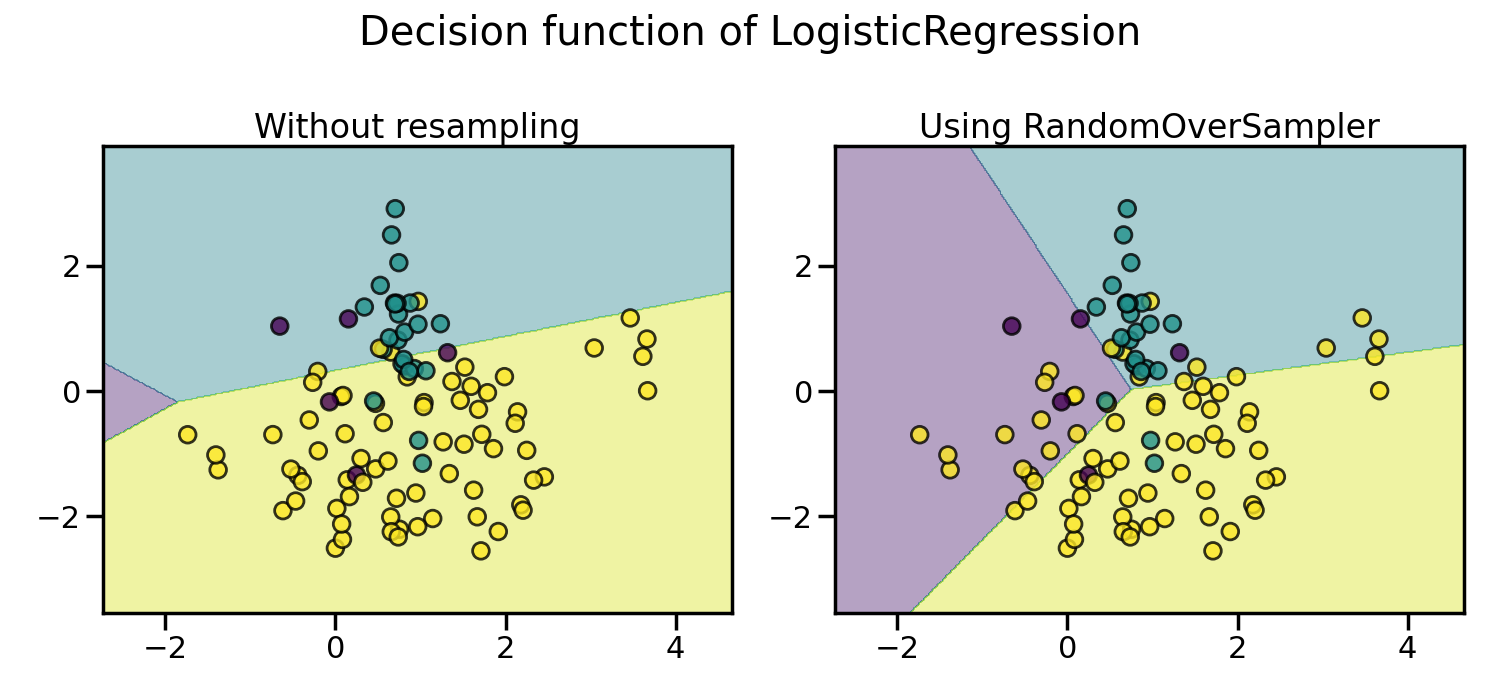

The parameter shrinkage allows to create a smoothed bootstrap, so the new samples are not overlapping anymore once using a smoothed bootstrap

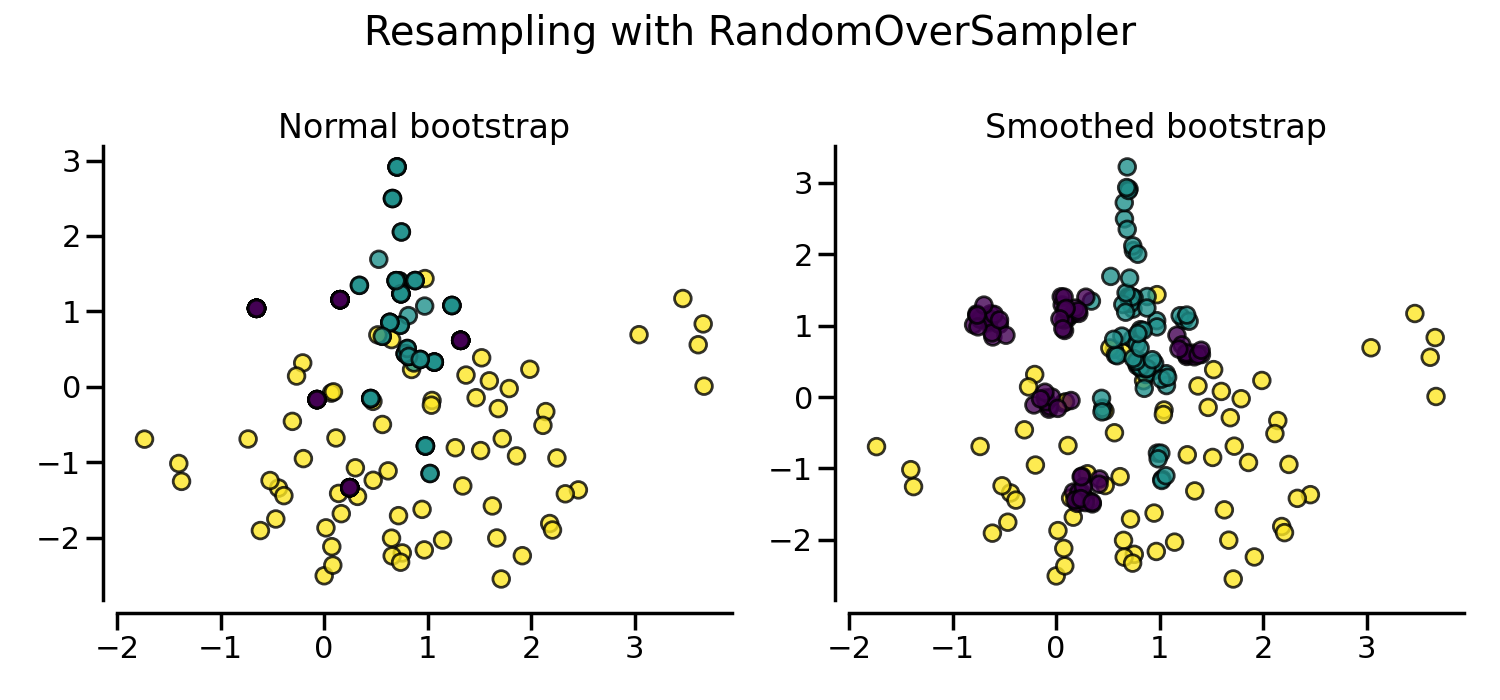

In [ ]:
X, y = make_classification(
    n_samples=5000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=3,
    n_clusters_per_class=1,
    weights=[0.01, 0.05, 0.94],
    class_sep=0.8, random_state=0
)

ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 4674), (1, 4674), (2, 4674)]


## 3.2) SMOTE and ADASYN

1. Two popular methods to over-sample minority classes:
    * Synthetic Minority Oversampling Technique (SMOTE)
    * Adaptive Synthetic (ADASYN) sampling method.

2. SMOTE might connect inliers and outliers while ADASYN might focus solely on outliers which, in both cases, might lead to a sub-optimal decision function.

3. Both SMOTE and ADASYN use the same algorithm to generate new samples. Considering a sample *xii*, a new sample *xnew* will be generated considering its k neareast-neighbors (corresponding to k_neighbors). For instance, the 3 nearest-neighbors are included in the blue circle as illustrated in the figure below. Then, one of these nearest-neighbors is selected and a sample is generated as follows: $x_{\text{new}} = x_i + \lambda \cdot (x_{zi} - x_i)$ where 𝜆 is a random number in the range [0, 1]

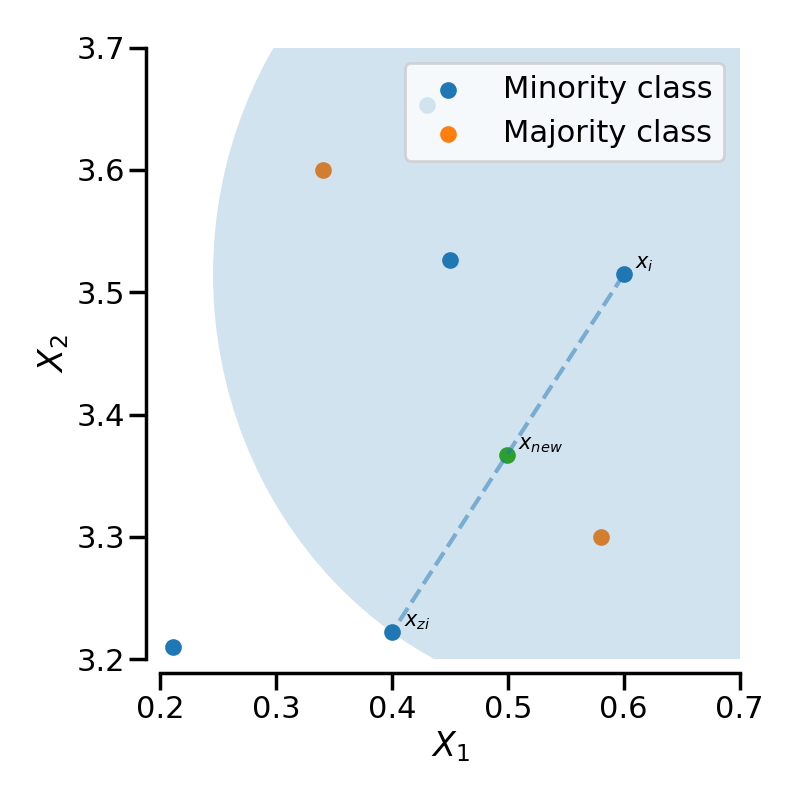


In [ ]:
X_resampled, y_resampled = SMOTE().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

X_resampled, y_resampled = ADASYN().fit_resample(X, y)
print(sorted(Counter(y_resampled).items()))

[(0, 4674), (1, 4674), (2, 4674)]
[(0, 4673), (1, 4662), (2, 4674)]


# 4) Hybrid

SMOTE and showed that this method can generate noisy samples by interpolating new points between marginal outliers and inliers. This issue can be solved by cleaning the space resulting from over-sampling.

In this regard, Tomek's link and edited nearest-neighbours are the two cleaning methods that have been added to the pipeline after applying SMOTE over-sampling to obtain a cleaner space. The two ready-to use classes imbalanced-learn implements for combining over- and undersampling methods are:

* SMOTETomek
* SMOTEENN

In [28]:
X, y = make_classification(
    n_samples=5000,
    n_features=2,
    n_informative=2,
    n_redundant=0,
    n_repeated=0,
    n_classes=3,
    n_clusters_per_class=1,
    weights=[0.01, 0.05, 0.94],
    class_sep=0.8, random_state=0
)

print('Original: ', sorted(Counter(y).items()))
smote_enn = SMOTEENN(random_state=0)
X_resampled, y_resampled = smote_enn.fit_resample(X, y)
print('SMOTEENN: ', sorted(Counter(y_resampled).items()))

smote_tomek = SMOTETomek(random_state=0)
X_resampled, y_resampled = smote_tomek.fit_resample(X, y)
print('SMOTETomek: ', sorted(Counter(y_resampled).items()))

Original:  [(0, 64), (1, 262), (2, 4674)]
SMOTEENN:  [(0, 4060), (1, 4381), (2, 3502)]
SMOTETomek:  [(0, 4499), (1, 4566), (2, 4413)]
